# LangGraph Basics

Over the course of this notebook, we will build an agentic RAG application using LangGraph with increasing complexity. We will start with a simple RAG flow, and then add conditional branching, memory, human in the loop, and more.

![HIL](./images/human_in_the_loop.png)

## Pre-work: Setup

You can set your environment variables locally in this notebook.

In [1]:
import os, json
from pymongo import MongoClient

In [ ]:
# If you are using your own MongoDB Atlas cluster, use the connection string for your cluster here
MONGODB_URI = os.environ.get("MONGODB_URI")
# Initialize a MongoDB Python client
mongodb_client = MongoClient(MONGODB_URI)
# Check the connection to the server
mongodb_client.admin.command("ping")

{'ok': 1}

**Optional**: enable LangSmith tracing, get free API key from https://smith.langchain.com/

In [4]:
# Set environment variables
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "mongodb-genai-devday"

Let's confirm that LangSmith tracing is enabled. If for some reason you can't see traces showing up in LangSmith, this is a great helper command to make sure you can trace!

In [5]:
from langsmith import utils as langsmith_utils

os.environ.get("LANGCHAIN_TRACING_V2")
langsmith_utils.tracing_is_enabled()

True

Because we're building a RAG application, we're going to create a vector database retriever containing MongoDB documentation.

### Pick an LLM provider of your choice below

In [6]:
SERVERLESS_URL = os.environ.get("SERVERLESS_URL")
# Can be one of "aws", "google" or "microsoft"
LLM_PROVIDER = "aws"

In [7]:
from langchain_core.load import load
import requests

# Obtain the Langchain LLM object from our serverless endpoint
llm_dict = requests.post(
    url=SERVERLESS_URL, json={"task": "get_llm", "data": LLM_PROVIDER}
).json()
llm = load(llm_dict["llm"], secrets_map=llm_dict["secrets_map"])

/var/folders/j2/s5h0fs4x15bbs1pbwhnxxvr80000gn/T/ipykernel_92709/1336701383.py:8: LangChainBetaWarning: The function `load` is in beta. It is actively being worked on, so the API may change.
  llm = load(llm_dict["llm"], secrets_map=llm_dict["secrets_map"])


### Define a Vector Store MongoDB Retriever

In [8]:
#  Database name
DB_NAME = "mongodb_genai_devday_agents"
# Name of the collection with full documents- used for summarization
FULL_COLLECTION_NAME = "mongodb_docs"
# Name of the collection for vector search- used for Q&A
VS_COLLECTION_NAME = "mongodb_docs_embeddings"
# Name of the vector search index
VS_INDEX_NAME = "vector_index"

In [9]:
# Connect to the `VS_COLLECTION_NAME` collection.
vs_collection = mongodb_client[DB_NAME][VS_COLLECTION_NAME]
# Connect to the `FULL_COLLECTION_NAME` collection.
full_collection = mongodb_client[DB_NAME][FULL_COLLECTION_NAME]

In [10]:
# Insert a dataset of MongoDB docs with embeddings into the `VS_COLLECTION_NAME` collection
with open(f"../data/{VS_COLLECTION_NAME}.json", "r") as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

print(f"Deleting existing documents from the {VS_COLLECTION_NAME} collection.")
vs_collection.delete_many({})
vs_collection.insert_many(data)
print(
    f"{vs_collection.count_documents({})} documents ingested into the {VS_COLLECTION_NAME} collection."
)

Deleting existing documents from the mongodb_docs_embeddings collection.
107 documents ingested into the mongodb_docs_embeddings collection.


In [11]:
# Insert a dataset of MongoDB documentation pages into the `FULL_COLLECTION_NAME` collection
with open(f"../data/{FULL_COLLECTION_NAME}.json", "r") as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

print(f"Deleting existing documents from the {FULL_COLLECTION_NAME} collection.")
full_collection.delete_many({})
full_collection.insert_many(data)
print(
    f"{full_collection.count_documents({})} documents ingested into the {FULL_COLLECTION_NAME} collection."
)

Deleting existing documents from the mongodb_docs collection.
20 documents ingested into the mongodb_docs collection.


In [12]:
from utils import create_index, check_index_ready

In [13]:
# Create vector index definition specifying:
# path: Path to the embeddings field
# numDimensions: Number of embedding dimensions- depends on the embedding model used
# similarity: Similarity metric. One of cosine, euclidean, dotProduct.
model = {
    "name": VS_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 384,
                "similarity": "cosine",
            }
        ]
    },
}

In [14]:
# Use the `create_index` function from the `utils` module to create a vector search index with the above definition for the `vs_collection` collection
create_index(vs_collection, VS_INDEX_NAME, model)

Creating the vector_index index


In [15]:
# Use the `check_index_ready` function from the `utils` module to verify that the index was created and is in READY status before proceeding
check_index_ready(vs_collection, VS_INDEX_NAME)

vector_index index status: READY
vector_index index definition: {'fields': [{'type': 'vector', 'path': 'embedding', 'numDimensions': 384, 'similarity': 'cosine'}]}


In [16]:
from sentence_transformers import SentenceTransformer

# Load the `gte-small` model using the Sentence Transformers library
embedding_model = SentenceTransformer("thenlper/gte-small")

/Users/mperini/Projects/genai-devday-notebooks-amsterdam/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
from typing import List
# Define a function that takes a piece of text (`text`) as input, embeds it using the `embedding_model` instantiated above and returns the embedding as a list
# An array can be converted to a list using the `tolist()` method
def get_embedding(text: str) -> List[float]:
    """
    Generate the embedding for a piece of text.

    Args:
        text (str): Text to embed.

    Returns:
        List[float]: Embedding of the text as a list.
    """
    embedding = embedding_model.encode(text)
    return embedding.tolist()

In [18]:
from langchain.schema import Document

def get_information_for_question_answering(user_query: str) -> str:
    """
    Retrieve information using vector search to answer a user query.

    Args:
    user_query (str): The user's query string.

    Returns:
    str: The retrieved information formatted as a string.
    """

    # Generate embedding for the `user_query` using the `get_embedding` function defined above
    query_embedding = get_embedding(user_query)

    # Define an aggregation pipeline consisting of a $vectorSearch stage, followed by a $project stage
    # Set the number of candidates to 150 and only return the top 5 documents from the vector search
    # In the $project stage, exclude the `_id` field and include only the `body` field and `vectorSearchScore`
    # NOTE: Use variables defined previously for the `index`, `queryVector` and `path` fields in the $vectorSearch stage
    pipeline = [
        {
            "$vectorSearch": {
                "index": VS_INDEX_NAME,
                "path": "embedding",
                "queryVector": query_embedding,
                "numCandidates": 150,
                "limit": 5,
            }
        },
        {
            "$project": {
                "_id": 0,
                "body": 1,
                "score": {"$meta": "vectorSearchScore"},
            }
        },
    ]

    # Execute the aggregation `pipeline` against the `vs_collection` collection and store the results in `results`
    results = vs_collection.aggregate(pipeline)
    # create a list of Document objects from the results
    docs = [Document(page_content=doc.get("body"), metadata={"score": doc.get("score")}) for doc in results]
    return docs

## Pre-work: Background Concepts

Feel free to skip this section if you're already familiar with the LangChain ChatModel and Messages concepts.

In this course, we'll be using [Chat Models](https://python.langchain.com/v0.2/docs/concepts/#chat-models), which take a sequence of messages as inputs and return chat messages as outputs.

Chat models in LangChain have a number of [default methods](https://python.langchain.com/v0.2/docs/concepts/#runnable-interface). For now we'll use `invoke`, which call the model on an input.

Chat models take [messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as input. LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. Let's create a list of messages. 

In [19]:
from langchain_core.messages import AIMessage, HumanMessage

# Some sample messages about orcas
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Marco"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Marco"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Marco

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Marco

I want to learn about the best place to see Orcas in the US.


The ChatModel interface is consistent across all chat models and models are typically initialized once at the start up each notebooks. The benefit here is that you can easily switch between models without changing the downstream code if you have strong preference for another provider.

Let's run our ChatModel on these Messages now!

In [20]:
llm.invoke(messages)

AIMessage(content="If you're looking to see Orcas (also known as killer whales) in the United States, one of the best places to go is the San Juan Islands in Washington State. Here's why:\n\n1. Resident population: The waters around the San Juan Islands are home to several pods of Southern Resident Killer Whales, which are present in the area for much of the year.\n\n2. Peak season: The best time to see Orcas is typically from mid-May to mid-October, with July and August being the peak months.\n\n3. Whale watching tours: There are numerous tour operators in the area offering boat trips specifically designed for whale watching.\n\n4. Land-based viewing: You can also sometimes spot Orcas from shore at places like Lime Kiln Point State Park on San Juan Island.\n\n5. High success rate: Due to the resident population and the frequency of transient Orcas, the chances of seeing these magnificent creatures are quite high during peak season.\n\nOther good locations in the US for Orca sightings 

## Part 1: LangGraph Basics

![Simple RAG](./images/simple_rag.png)

We're going to set up a simple RAG workflow while introducing several LangGraph concepts. We're then going to step into LangSmith and see how it can help us while we iterate on our application

### State

Great, now that we've tested out our ChatModel on some Messages let's start learning about some of our Agent primitives. Our first concept is [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

State is one of the most important concepts in an Agent. When defining a Graph, you must pass in a schema for State. The State schema serves as the input schema for all Nodes and Edges in the graph. Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys. 

The State of our RAG application will keep track of the user's question, our RAG app's LLM generated response, and the list of retrieved relevant documents.

In [21]:
from langchain.schema import Document
from typing import List
from typing_extensions import TypedDict

class State(TypedDict):
    """
    Attributes:
        question: The user's question
        generation: The LLM's generation
        documents: List of helpful documents retrieved by the RAG pipeline
    """
    question: str
    generation: str
    documents: List[Document]

### Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions. As mentioned above, Nodes take in your graph's State as input. 

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access each key in the state, in our case, we could use `state["question"]`.
  
Nodes return any updates to the state that they want to make. By default, the new value returned by each node will override the prior state value. You can implement custom handling for updates to State using State Reducers, which we will see later in the session.

Here, we're going to set up two nodes for our RAG flow:
1. retrieve_documents: Retrieves documents from our vector store
2. generate_response: Generates an answer from our documents

In [22]:
from langchain_core.messages import HumanMessage

def retrieve_documents(state: State):
    """
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    documents = get_information_for_question_answering(question)
    return {"documents": documents}

RAG_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.

Question: {question} 
Context: {context} 
Answer:"""

def generate_response(state: State):
    """
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    # Invoke our LLM with our RAG prompt
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation}

### Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) define how your agentic applications progresses from each Node to the next Node.
- Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.
- [Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) are used want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic. Note that these functions often use values from our graph's State to determine how to traverse.

We'll add some useful conditional edges later, but for now let's take a look at an example.

In [23]:
from typing import Literal

def conditional_edge_example(state) -> Literal["node_1", "node_2"]:
    # Often, we will use state to decide on the next node to visit
    field_1 = state['field_1'] 
    field_2 = state['field_2']
    if field_1 > field_2:
        return "node_1"
    return "node_2"

### Graph

Great! We now have defined the schema for our State, written logic for two Nodes, and learned about Edges. Let's stitch those components together to define our simple RAG graph

First, we instantiate a graph builder with our State. The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.

In [24]:
from langgraph.graph import StateGraph
graph_builder = StateGraph(State)

Next, we add our two defined nodes to our Graph.

In [25]:
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)

We then define the shape of our graph by adding edges between the nodes.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

In [26]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

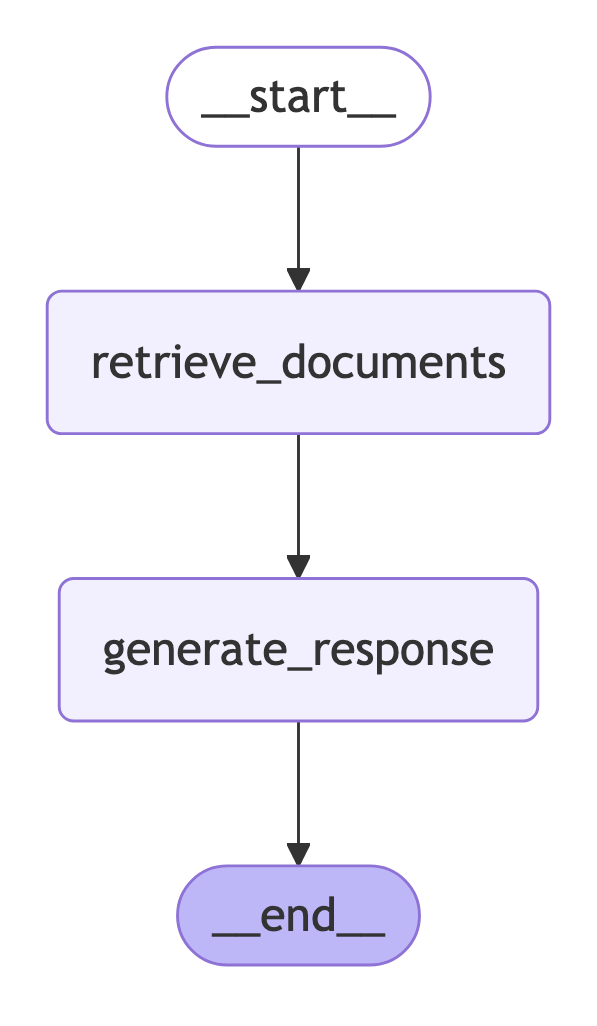

In [27]:
from utils import visualize_graph
simple_rag_graph = graph_builder.compile()

visualize_graph(simple_rag_graph)

### Running our Graph

Now that our graph is defined, let's invoke it!

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol. This provides a standard way to execute LangChain components. `invoke` is one of the standard methods in this interface.

The input is a dictionary `{"question": "What is MongoDB used for?"}`, which sets the initial value for our graph's state dictionary. Note that we didn't need to pass in all of the keys of our dictionary.

Our graph executes as follows:
1. When `invoke` is called, the graph starts execution from the `START` node.
2. It progresses to `retrieve_documents` and invokes our retriever on the `question` defined in our State. It then writes the retrieved `documents` to State.
3. It progresses to `generate_response` and makes an LLM call to generate an answer, using our retrieved `documents`.
4. Finally, it progresses to the `END` node.

Each node function receives the current state and returns a new value, which overrides the graph state.

In [28]:
question = "What are some best practices for data backups in MongoDB?"
simple_rag_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GENERATE RESPONSE---


{'question': 'What are some best practices for data backups in MongoDB?',
 'generation': AIMessage(content='Here are some best practices for data backups in MongoDB:\n\n1. For sharded clusters, stop the balancer and use fsync or db.fsyncLock() to block writes during backups when using mongodump and mongorestore.\n\n2. Consider using coordinated backup and restore processes like MongoDB Atlas, Cloud Manager, or Ops Manager to maintain transaction atomicity across shards.\n\n3. Use file system snapshots to back up each component individually if your system configuration allows, as this may be more efficient than MongoDB tools.', additional_kwargs={'usage': {'prompt_tokens': 833, 'completion_tokens': 116, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 949}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0', 'model_name': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens':

Congrats on running your first LangGraph application! `invoke` runs the entire graph synchronously. This waits for each step to complete before moving to the next. It returns the final state of the graph after all nodes have executed, which is what we see above.

Let's take a look in LangSmith!

## Part 2: Control Flow with Conditional Edges


![Corrective RAG](./images/conditional_rag.png)

In this section, we're going to add a few techniques that can improve our RAG workflow. Specifically, we'll introduce
- Document Grading: Are the documents fetched by the retriever actually relevant to the user's question?

We're also going to add some constraints to the inputs and outputs of our application for the best user experience.

By the end of this section, we'll have a more complex corrective RAG workflow! Then, we'll hop into LangSmith and walk through how we can evaluate that our application is actually improving as we add new techniques.

### Structured Outputs

Some LLMs provide support for Structured Outputs, which provides a typing guarantee for the output schema of the LLM's response. Here, we can use BaseModel from pydantic to define a specific return type. The provided description helps the LLM generate the value for the field.

We can hook this up to our previously defined `llm` using `with_structured_output`. Now, when we invoke our `grade_documents_llm`, we can expect the returned object to contain the expected field.

In [29]:
from pydantic import BaseModel, Field

class GradeDocuments(BaseModel):
    is_relevant: bool = Field(
        description="The document is relevant to the question, true or false"
    )

grade_documents_llm = llm.with_structured_output(GradeDocuments)
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score true or false to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"

In [30]:
from langchain_core.messages import SystemMessage

def grade_documents(state):
    """
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---GRADE DOCUMENTS---")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    for d in documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.is_relevant
        if grade:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}

Let's make sure that at least some documents are relevant if we are going to respond to the user! To do this, we need to add a conditional edge. Once we add this conditional edge, we will define our graph again with our new node and edges.

In [31]:
def decide_to_generate(state):
    """
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---"
        )
        return "none relevant"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "some relevant"

Let's put our graph together!

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


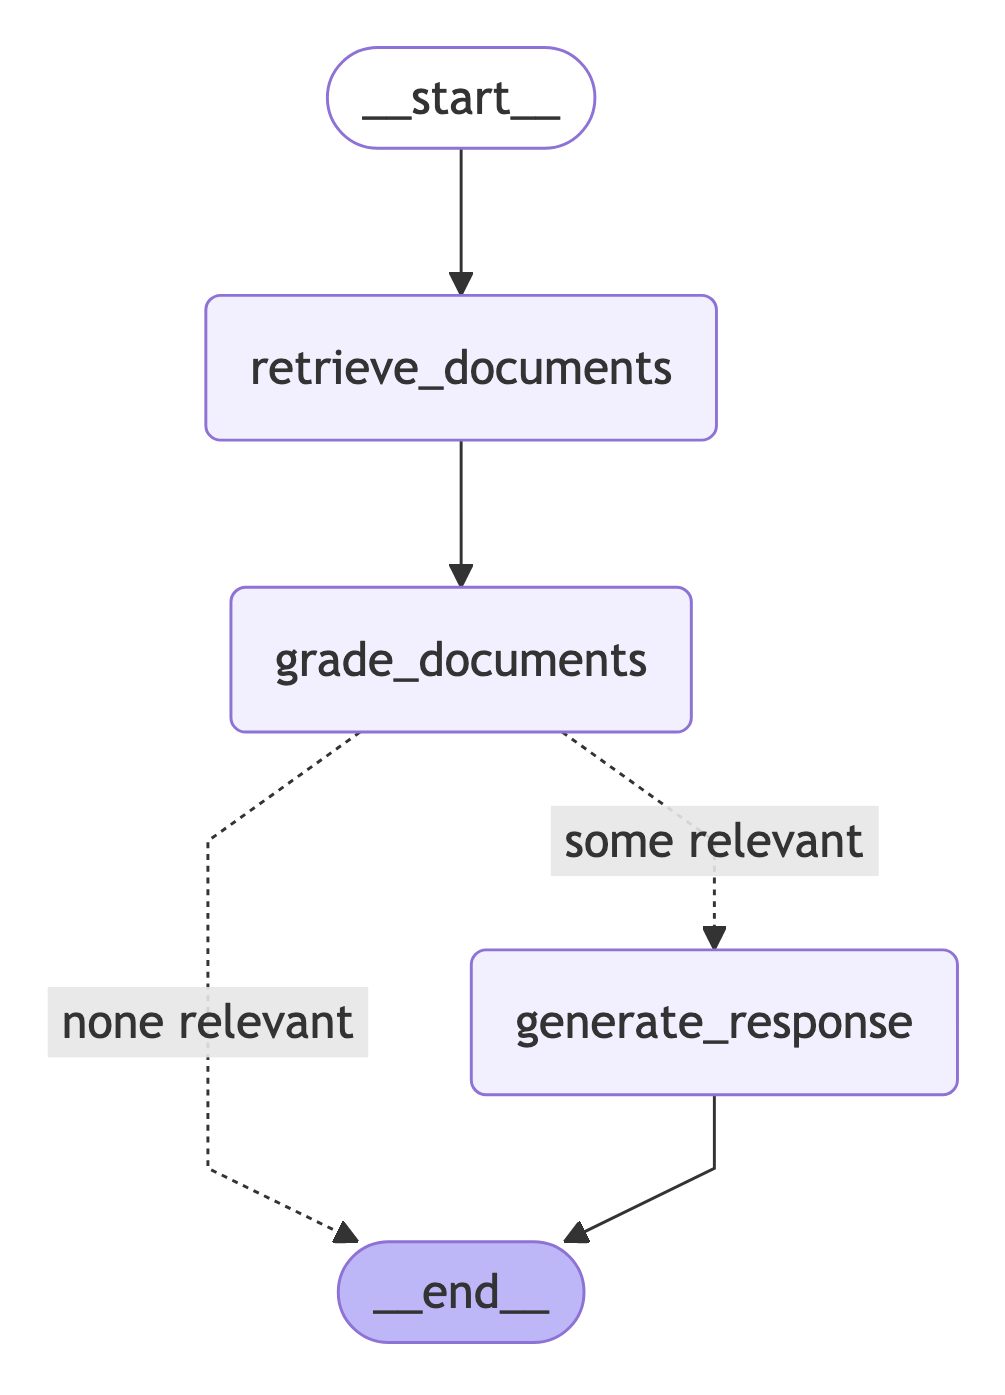

In [32]:
from langgraph.graph import StateGraph
from langgraph.graph import START, END

graph_builder = StateGraph(State)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)    # new node!
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")    # edited edge
graph_builder.add_conditional_edges(    # new conditional edge
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_edge("generate_response", END)

document_grading_graph = graph_builder.compile()
visualize_graph(document_grading_graph)

Let's try to invoke our graph again, this time with a question about something totally irrelevant, like pokemon.

In [33]:
question = "What is your favorite pokemon?"
document_grading_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---


{'question': 'What is your favorite pokemon?', 'documents': []}

## Part 3: Memory and Human-in-the-Loop

### Short Term Memory

In every example so far, [state has been transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution. If we invoke our graph for a second time, we are starting with a fresh state. This limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step. This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

Before we set up memory in our application, let's edit our State and Nodes so that instead of acting a single "question", we instead act on a list of "questions and answers".

We'll call our list "messages". These existing messages will all be used for our retrieval step. And at the end of our flow when our LLM responds, we will add the latest question and answer to our "messages" history. 

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

In this section, we'll talk about the different types of memory in LangGraph, and how we can use them to enable HIL workflows.

In [34]:
from langchain_core.messages import get_buffer_string
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.managed.is_last_step import RemainingSteps
from typing import List
from typing_extensions import Annotated

class State(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], add_messages]     # We now track a list of messages
    documents: List[Document]
    remaining_steps: RemainingSteps  # This is a special field that is used to track the remaining steps in the graph
    # We removed generation

Now let's edit our existing Nodes to use `messages` in addition to `question`, specifically for grading document relevance, and generating a response.

In [35]:
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a conversation between a user and an AI assistant, and user's latest question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, definitely grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals that are not relevant at all. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the conversation so far: \n\n {conversation} \n\n Here is the user question: \n\n {question}"
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    conversation = get_buffer_string(state["messages"])

    filtered_docs = []
    for d in documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question, conversation=conversation)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.is_relevant
        if grade:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}

In [36]:
RAG_PROMPT_WITH_CHAT_HISTORY = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
The pre-existing conversation may provide important context to the question.
Use three sentences maximum and keep the answer concise.

Existing Conversation:
{conversation}

Latest Question:
{question}

Additional Context from Documents:
{context} 

Answer:"""

def generate_response(state: State):
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    conversation = get_buffer_string(state["messages"])
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    # RAG generation
    rag_prompt_formatted = RAG_PROMPT_WITH_CHAT_HISTORY.format(context=formatted_docs, conversation=conversation, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "messages": [HumanMessage(content=question), generation],   # Add generation to our messages_list
    }

#### Local Memory

Cool, now let's define our graph and add some local memory!

One of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


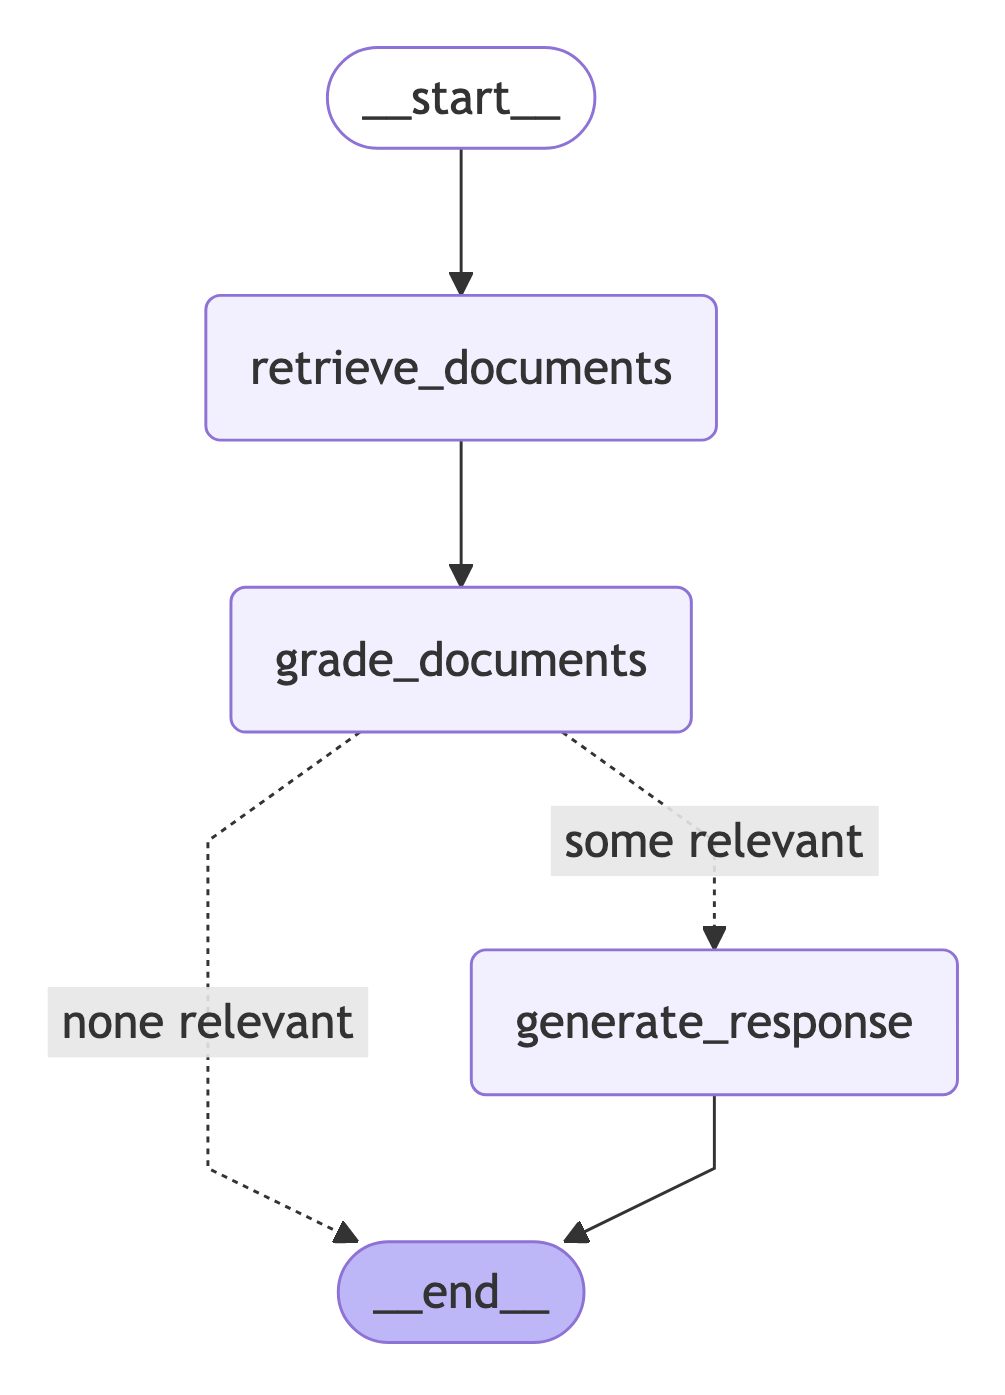

In [37]:
# Define our graph
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
visualize_graph(graph)

#### MongoDB Checkpointer

Now let's use `MongoDBSaver` to persist the state of our graph in the MongoDB database.

![Checkpoint Thread](./images/checkpoint_thread.png)

In [38]:
from langgraph.checkpoint.mongodb import MongoDBSaver

# Initialize a MongoDB checkpointer
mongodb_saver = MongoDBSaver(mongodb_client)

graph = graph_builder.compile(checkpointer=mongodb_saver)

#### Threads

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

In [39]:
import uuid
thread_id = str(uuid.uuid4())

In [40]:
config = {"configurable": {"thread_id": thread_id}}
question = "What are some best practices for data backups in MongoDB?"
response = graph.invoke({"question": question}, config)
print(response)

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
{'question': 'What are some best practices for data backups in MongoDB?', 'messages': [HumanMessage(content='What are some best practices for data backups in MongoDB?', additional_kwargs={}, response_metadata={}, id='eee029c0-4375-4ea0-8e06-b2f542fcfcb9'), AIMessage(content='Some best practices for data backups in MongoDB include:\n\n1. For sharded clusters, stop the balancer and use `fsync` or `db.fsyncLock()` to block writes during backups when using `mongodump` and `mongorestore`.\n\n2. Consider using coordinated backup and restore processes like MongoDB Atlas, Cloud Manager, or Ops Manager for maintaining atomicity guarantees across shards.\n\n3. If your system configuratio

Let's ask a follow-up with the same thread_id!

In [41]:
config = {"configurable": {"thread_id": thread_id}}
question = "What data format do you support?"
response = graph.invoke({"question": question}, config)
for m in response["messages"]:
    m.pretty_print()

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
================================ Human Message =================================

What are some best practices for data backups in MongoDB?
================================== Ai Message ==================================

Some best practices for data backups in MongoDB include:

1. For sharded clusters, stop the balancer and use `fsync` or `db.fsyncLock()` to block writes during backups when using `mongodump` and `mongorestore`.

2. Consider using coordinated backup and restore processes like MongoDB Atlas, Cloud Manager, or Ops Manager for maintaining atomicity guarantees across shards.

3. If your system configuration allows, use file system snapshots to back up each comp

### Human-in-the-Loop and "Command" module

![HIL](./images/human_in_the_loop.png)

Now, let's talk about the motivations for human-in-the-loop:

1. **Approval** - We can interrupt our agent, surface state to a user, and allow the user to accept an action
2. **Review and Edit** - You can view the state and edit it if necessary

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows. 

Today, we'll focus on `interrupt()`

When building human-in-the-loop into Python programs, one common way to do this is with the input function. With this, your program pauses, a text box pops up in your terminal, and whatever you type is then used as the response to that function. You use it like the below:

`response = input("Your question here")`

We’ve tried to emulate this developer experience by adding a new function to LangGraph: interrupt. You can use this in much the same way as input:

`response = interrupt("Your question here")`

This is designed to work in production settings. When you do this, it will pause execution of the graph, mark the thread you are running as interrupted, and put whatever you passed as an input to interrupt into the persistence layer. This way, you can check the thread status, see that it’s interrupted, check the message, and then based on that invoke the graph again (in a special way) to pass your response back in:

`graph.invoke(Command(resume="Your response here"), thread)`

Note that it doesn’t function exactly the same as input (it reruns any work in that node done before this is called, but no previous nodes). This ensures interrupted threads don’t take up any resources (beyond storage space), and can be resumed many months later, on a different machine, etc.

As an example, let's add an interrupt step before we generate a response. We can use this opportunity view our state.

In [59]:
from langgraph.types import interrupt, Command

def generate_response(state: State):
    # We interrupt the graph, and ask the user for some additional context
    additional_context = interrupt("Do you have anything else to add that you think is relevant?")
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    # For simplicity, we'll just append the additional context to the conversation history
    conversation = get_buffer_string(state["messages"]) + additional_context
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT_WITH_CHAT_HISTORY.format(context=formatted_docs, conversation=conversation, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "messages": [HumanMessage(content=question), generation],
    }

In [60]:
# Define our graph
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })


graph = graph_builder.compile(checkpointer=mongodb_saver)
# visualize_graph(graph)

In [61]:
thread_id_3 = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id_3}}
question = "What are some best practices for data backups in MongoDB?"
graph.invoke({"question": question}, config)

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---


{'question': 'What are some best practices for data backups in MongoDB?',
 'messages': [],
 'documents': [Document(metadata={'score': 0.9431124925613403}, page_content='# Backup and Restore Sharded Clusters\n\nThe following tutorials describe backup and restoration for sharded clusters:\n\nTo use `mongodump` and `mongorestore` as a backup strategy for sharded clusters, you must stop the sharded cluster balancer and use the `fsync` command or the `db.fsyncLock()` method on `mongos` to block writes on the cluster during backups.\n\nSharded clusters can also use one of the following coordinated backup and restore processes, which maintain the atomicity guarantees of transactions across shards:\n\n- MongoDB Atlas\n\n- MongoDB Cloud Manager\n\n- MongoDB Ops Manager\n\nUse file system snapshots back up each component in the sharded cluster individually. The procedure involves stopping the cluster balancer. If your system configuration allows file system backups, this might be more efficient 

Cool! Our graph has been interrupted! 

We can get the state and look at the next node to call.

In [62]:
state = graph.get_state(config)
state.next

('generate_response',)

Now, we'll introduce a nice trick. In order to resume the graph's execution, we can invoke the graph with an input `Command`.

`Command` is a special type that when returned from a node specifies not only the update to the state (as usual) but also which node to go to next. This allows nodes to more directly control which nodes are executed after-the-fact. We can use it to resume the graph's execution after an interrupt!

`graph.invoke(Command(resume="Your response here"), thread)`

In [63]:
graph.invoke(Command(resume="I am using MongoDB Atlas"), config)

---GENERATE RESPONSE---


{'question': 'What are some best practices for data backups in MongoDB?',
 'messages': [HumanMessage(content='What are some best practices for data backups in MongoDB?', additional_kwargs={}, response_metadata={}, id='28a8ba90-85da-4fe8-be86-72c605014a9b'),
  AIMessage(content='Some best practices for data backups in MongoDB include:\n\n1. Use MongoDB Atlas, Cloud Manager, or Ops Manager for coordinated backups that maintain transaction atomicity across shards.\n2. If using mongodump, stop the sharded cluster balancer and use fsync to block writes during backups.\n3. Consider file system snapshots for each cluster component if your system configuration allows, as this may be more efficient than MongoDB tools.', additional_kwargs={'usage': {'prompt_tokens': 385, 'completion_tokens': 97, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 482}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0', 'model_name': 'anthr

We quickly added a human in the loop to our graph using `interrupt()` and `Command`!

`Command` can be used, as a replacement of conditional edges, inside nodes as well!
Let's incorporate the conditional edge logic inside the `grade_documents` node.

In [64]:
def grade_documents(state: State) -> Command[Literal["generate_response", "__end__"]]: # the return type is needed to visualize the connections in the graph
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    conversation = get_buffer_string(state["messages"])

    filtered_docs = []
    for d in documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question, conversation=conversation)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.is_relevant
        if grade:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    # Add new Command logic to route to the next node
    if len(filtered_docs) > 0:
        return Command(
            # state update
            update={"documents": filtered_docs},
            # control flow
            goto="generate_response"
        )
        
    return Command(
                # state update
                update={
                    "documents": filtered_docs,
                    "messages": [HumanMessage(content="No relevant documents found")]
                },
                # control flow
                goto=END
            )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


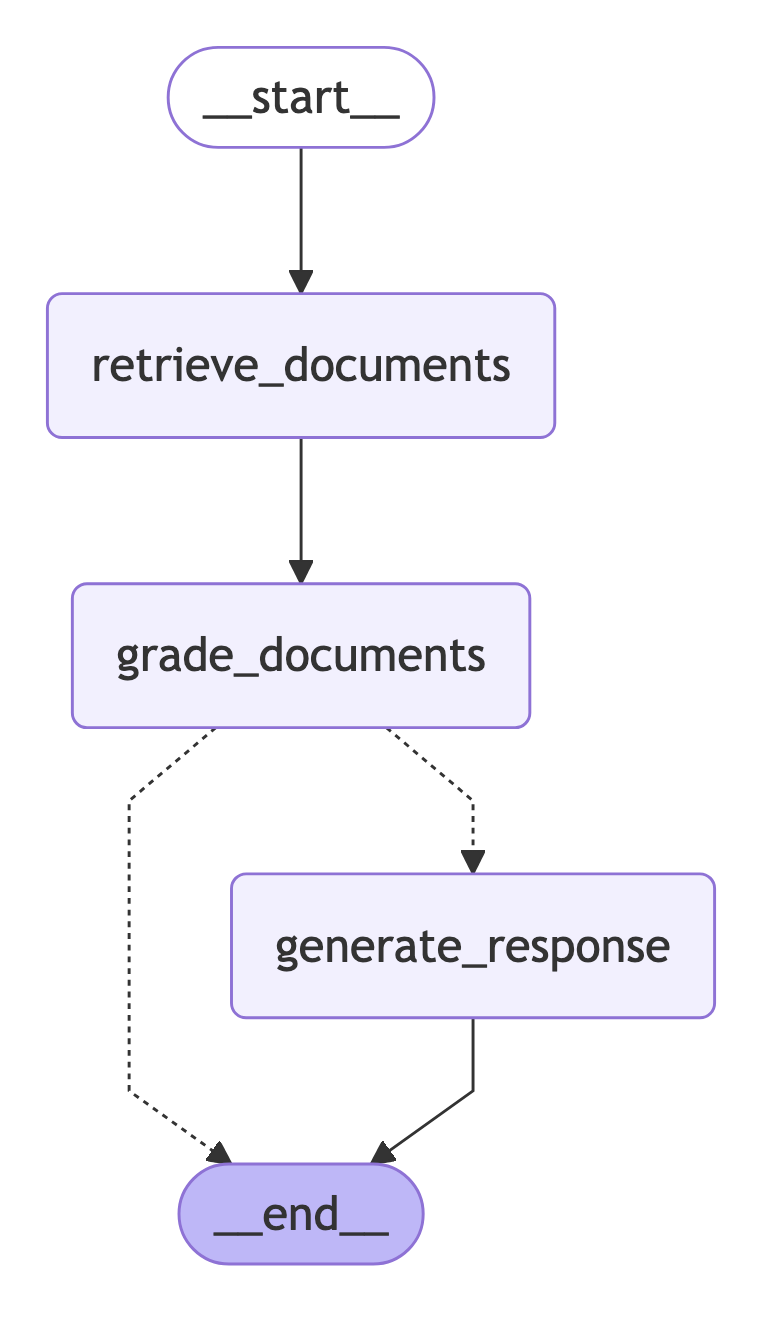

In [65]:
# Define our graph
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
# We removed the conditional edge


graph = graph_builder.compile(
    name="mongodb_rag_pipeline",
    checkpointer=mongodb_saver)
visualize_graph(graph)

In [66]:
thread_id_4 = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id_4}}
question = "What are some best practices for data backups in MongoDB?"
graph.invoke({"question": question}, config)

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---


{'question': 'What are some best practices for data backups in MongoDB?',
 'messages': [],
 'documents': [Document(metadata={'score': 0.9431124925613403}, page_content='# Backup and Restore Sharded Clusters\n\nThe following tutorials describe backup and restoration for sharded clusters:\n\nTo use `mongodump` and `mongorestore` as a backup strategy for sharded clusters, you must stop the sharded cluster balancer and use the `fsync` command or the `db.fsyncLock()` method on `mongos` to block writes on the cluster during backups.\n\nSharded clusters can also use one of the following coordinated backup and restore processes, which maintain the atomicity guarantees of transactions across shards:\n\n- MongoDB Atlas\n\n- MongoDB Cloud Manager\n\n- MongoDB Ops Manager\n\nUse file system snapshots back up each component in the sharded cluster individually. The procedure involves stopping the cluster balancer. If your system configuration allows file system backups, this might be more efficient 

In [67]:
graph.invoke(Command(resume="Nothing else to add."), config)

---GENERATE RESPONSE---


{'question': 'What are some best practices for data backups in MongoDB?',
 'messages': [HumanMessage(content='What are some best practices for data backups in MongoDB?', additional_kwargs={}, response_metadata={}, id='e4883816-e33a-41a5-b8fe-a076bf543357'),
  AIMessage(content='Some best practices for data backups in MongoDB include:\n\n1. Use coordinated backup processes like MongoDB Atlas, Cloud Manager, or Ops Manager to maintain atomicity across shards.\n\n2. If using mongodump, stop the sharded cluster balancer and use fsync to block writes during backups.\n\n3. Consider using file system snapshots to back up each component individually if your system configuration allows it, as this may be more efficient than MongoDB tools.', additional_kwargs={'usage': {'prompt_tokens': 385, 'completion_tokens': 100, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 485}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'

### 1.2. Building ReAct Agent using LangGraph Pre-built

LangGraph offers pre-built libraries for common architectures, allowing us to quickly create architectures like ReAct or multi-agent architacture. A full list of pre-built libraries can be found here: https://langchain-ai.github.io/langgraph/prebuilt/#available-libraries 

In the last workflow, we have seen how we can build a ReAct agent from scratch. Now, we will show how we can leverage the LangGraph pre-built libraries to achieve similar results. 

![react_2](./images/server_subagent.png)

Our **MongoDB server subagent** is responsible for all customer queries related to the invoices. 

#### Defining tools and prompt
Similarly, let's first define a set of tools and our agent prompt below. 

In [68]:
from langchain_core.tools import tool

@tool
def get_mongodb_server_info() -> dict:
    """
    Retrieve metadata about the connected MongoDB server instance.

    This includes version, storage engines, JavaScript engine, and system-level information.
    Useful for diagnostics or understanding server capabilities.

    Returns:
        dict: MongoDB server information such as version, build, and supported features.
    """
    return mongodb_client.server_info()


@tool
def list_all_mongodb_databases() -> list[str]:
    """
    List all available databases in the connected MongoDB server.

    Use this tool to discover valid database names that can then be passed to other tools
    such as `list_collections_in_database`.

    Returns:
        list[str]: Names of all accessible MongoDB databases.
    """
    return mongodb_client.list_database_names()


@tool
def list_collections_in_database(database_name: str) -> dict:
    """
    Retrieve all collections and database-level statistics for a specified MongoDB database.

    This tool combines collection metadata and stats into one response. Use it after calling
    `list_all_mongodb_databases` to ensure the database name is valid.

    Args:
        database_name (str): The name of the MongoDB database to inspect.

    Returns:
        dict: A dictionary containing:
            - 'database': The name of the database.
            - 'collections': A list of collection names in the database.
            - 'stats': A dictionary with metrics like object count, storage size, index size, etc.
    """
    db = mongodb_client[database_name]
    collections = db.list_collection_names()
    stats = db.command("dbstats")
    return {
        "database": database_name,
        "collections": collections,
        "stats": stats
    }

mongodb_tools = [
    get_mongodb_server_info,
    list_all_mongodb_databases,
    list_collections_in_database
]


In [97]:
mongodb_subagent_prompt = """
    You are a subagent among a team of assistants. You are specialized in retrieving and interpreting MongoDB metadata and structural information. You are routed for questions specifically related to MongoDB server info, database exploration, and collection listings — only respond to those.

    You have access to three tools. These tools enable you to inspect the structure and capabilities of the connected MongoDB instance. Here are the tools:
    - get_mongodb_server_info: This tool retrieves server-level information such as version, storage engines, and system details.
    - list_all_mongodb_databases: This tool lists all available databases in the MongoDB instance.
    - list_collections_in_database: This tool retrieves both the list of collections and database statistics for a specified database.

    If the information is not available or an error occurs, inform the user clearly and ask if they would like to try a different query or database.

    CORE RESPONSIBILITIES:
    - Retrieve and summarize MongoDB server information for diagnostic or overview purposes
    - Help users explore available databases and their internal structure (collections and stats)
    - Combine data from multiple sources to provide a clear view of how MongoDB is organized
    - Always maintain a professional, informative, and helpful tone
    - You always need to provide a summary of the information you have retrieved.

    You may have additional context that you should use to help answer the user's query. It will be provided to you below:
"""

#### Using the pre-built library
Now, let's put them together by using the pre-built ReAct agent library

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


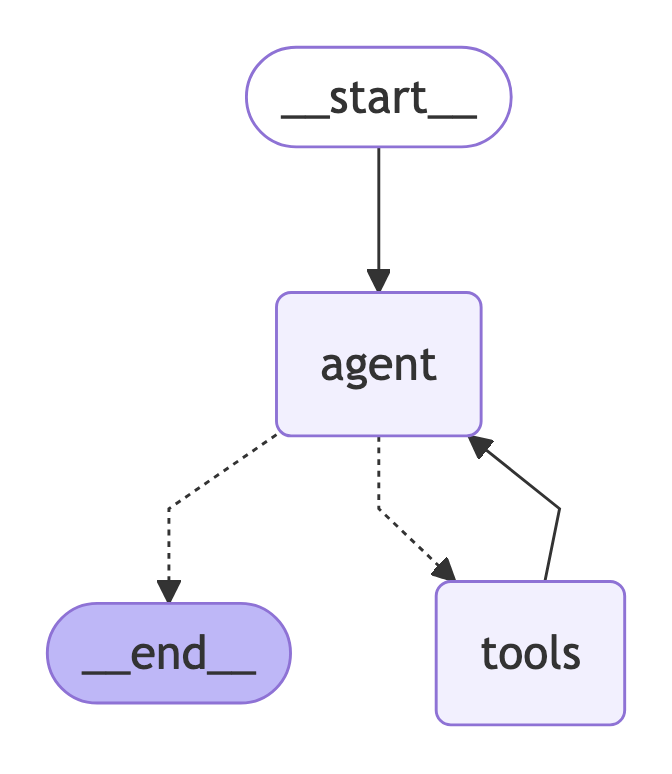

In [98]:
from langgraph.prebuilt import create_react_agent

# Define the subagent
mongodb_server_subagent = create_react_agent(
    llm,
    tools=mongodb_tools,
    name="mongodb_server_subagent",
    prompt=mongodb_subagent_prompt,
    state_schema=State,
    checkpointer=mongodb_saver,
)

# Visualize the graph
visualize_graph(mongodb_server_subagent)


#### Testing!
Let's try our new agent out!

In [99]:
thread_id = uuid.uuid4()
question = "List me the available databases and the collections for the mongodb devday"
config = {"configurable": {"thread_id": thread_id}}

result = mongodb_server_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

List me the available databases and the collections for the mongodb devday
================================== Ai Message ==================================
Name: mongodb_server_subagent

Certainly! I'd be happy to help you list the available databases and collections for the MongoDB instance you mentioned. To accomplish this, we'll need to use two of our available tools: first to list all databases, and then to get the collections for the specific database you mentioned.

Let's start by listing all available databases:
Tool Calls:
  list_all_mongodb_databases (toolu_bdrk_01EfmV3iPoHFXTDJbojHotXB)
 Call ID: toolu_bdrk_01EfmV3iPoHFXTDJbojHotXB
  Args:
================================= Tool Message =================================
Name: list_all_mongodb_databases

["checkpointing_db", "mongodb_genai_devday_agents", "sample_mflix", "admin", "local"]
================================== Ai Message =============

## Part 2: Building multi-agent architecture

Now that we have two sub-agents that have different capabilities. How do we make sure customer tasks are appropriately routed between them? 

This is where the supervisor oversees the workflow, invoking appropriate subagents for relevant inquiries. 


A **multi-agent architecture** offers several key benefits:
- Specialization & Modularity – Each sub-agent is optimized for a specific task, improving system accuracy 
- Flexibility – Agents can be quickly added, removed, or modified without affecting the entire system

![supervisor](./images/multi_agent.png)

We will show how we can utilize the pre-built supervisor to quickly create the multi-agent architecture. 

First, we will create a set of instructions for our supervisor. 

In [100]:
supervisor_prompt = """
You are an expert assistant tasked with helping users understand and troubleshoot MongoDB systems. 
Your job is to coordinate a team of specialized subagents to ensure that user queries are handled accurately and efficiently. 
You serve as the supervisor and planner for this multi-agent system, selecting the right subagent for each part of a user's request.

You have access to the following two subagents:

1. mongodb_server_subagent: This subagent specializes in retrieving live metadata from the MongoDB server. 
It can access information such as server version, available databases, collection names, and statistics about storage or object sizes. 
Use this subagent when the user asks about the structure, organization, or status of the MongoDB server or databases.

2. mongodb_rag_pipeline: This subagent is powered by a retrieval-augmented generation (RAG) pipeline. 
It specializes in answering questions about MongoDB based on official documentation. 
Use this subagent when the user asks conceptual questions (e.g., "How does indexing work?", "What is the difference between sharding and replication?", etc.)

Your job is to read the user's message and decide which subagent should be called next.
Some queries may require multiple steps involving both subagents — plan accordingly and route to the most relevant subagent for the current step.
"""


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


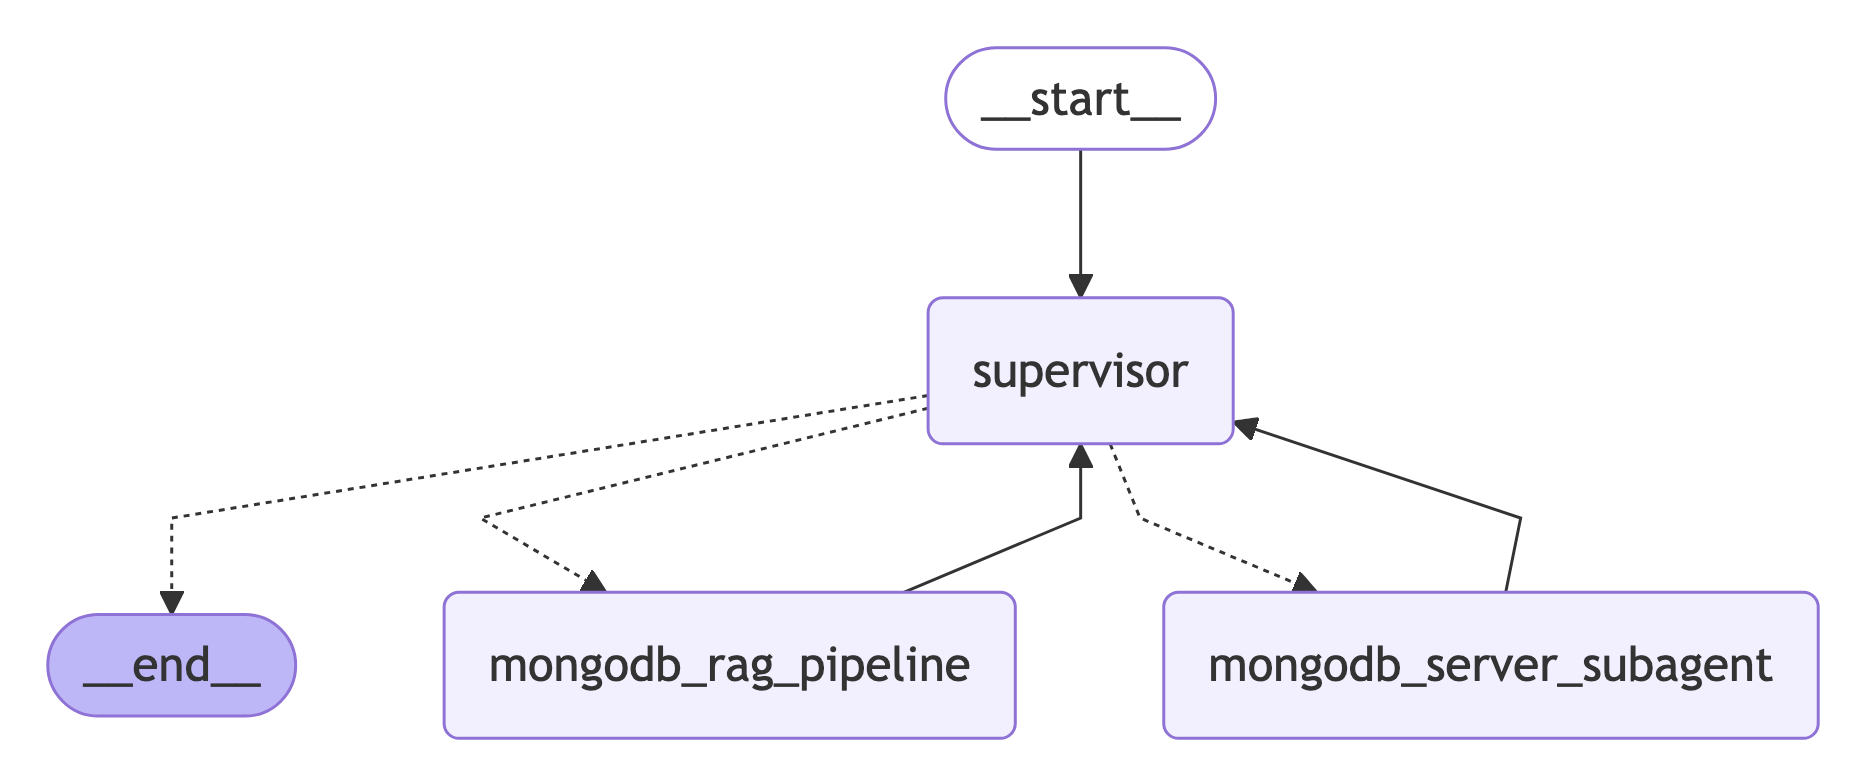

In [101]:
from langgraph_supervisor import create_supervisor

mongodb_rag_pipeline = graph
# Create supervisor workflow
supervisor_prebuilt_workflow = create_supervisor(
    agents=[mongodb_rag_pipeline, mongodb_server_subagent],
    output_mode="last_message", # alternative is full_history
    model=llm,
    prompt=(supervisor_prompt), 
    state_schema=State
)

supervisor_agent = supervisor_prebuilt_workflow.compile(name="mongodb_supervisor_agent", checkpointer=mongodb_saver)

# Visualize the graph
visualize_graph(supervisor_agent)

In [111]:
thread_id = uuid.uuid4()
question = "What are some best practices for data backups in MongoDB?"
config = {"configurable": {"thread_id": thread_id}}

result = supervisor_agent.invoke({
    "messages": [HumanMessage(content=question)],
    "question": question
}, config=config)
for message in result["messages"]:
    message.pretty_print()

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
================================ Human Message =================================

What are some best practices for data backups in MongoDB?
================================== Ai Message ==================================
Name: supervisor

To answer this question about best practices for data backups in MongoDB, we should consult the official MongoDB documentation. This type of conceptual question is best handled by our mongodb_rag_pipeline subagent, which has access to the official MongoDB documentation. Let's transfer the question to this subagent.
Tool Calls:
  transfer_to_mongodb_rag_pipeline (toolu_bdrk_013SPhVpmvydkfm89MwGmSWj)
 Call ID: toolu_bdrk_013SPhVpmvydkfm89MwGmSWj
  Args:
================================= Tool Message =======================

In [112]:
state = supervisor_agent.get_state(config)
state.next

('mongodb_rag_pipeline',)

In [113]:
result = supervisor_agent.invoke(Command(resume="Nothing else to add."), config)
for message in result["messages"]:
    message.pretty_print()

---GENERATE RESPONSE---
================================ Human Message =================================

What are some best practices for data backups in MongoDB?
================================== Ai Message ==================================
Name: supervisor

To answer this question about best practices for data backups in MongoDB, we should consult the official MongoDB documentation. This type of conceptual question is best handled by our mongodb_rag_pipeline subagent, which has access to the official MongoDB documentation. Let's transfer the question to this subagent.
Tool Calls:
  transfer_to_mongodb_rag_pipeline (toolu_bdrk_013SPhVpmvydkfm89MwGmSWj)
 Call ID: toolu_bdrk_013SPhVpmvydkfm89MwGmSWj
  Args:
================================= Tool Message =================================
Name: transfer_to_mongodb_rag_pipeline

Successfully transferred to mongodb_rag_pipeline
================================== Ai Message ==================================

Some best practices for data 

In [114]:
# thread_id = uuid.uuid4()
question = "List me the available databases and the collections for the mongodb devday"
config = {"configurable": {"thread_id": thread_id}}

result = supervisor_agent.invoke({
    "messages": [HumanMessage(content=question)]
}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What are some best practices for data backups in MongoDB?
================================== Ai Message ==================================
Name: supervisor

To answer this question about best practices for data backups in MongoDB, we should consult the official MongoDB documentation. This type of conceptual question is best handled by our mongodb_rag_pipeline subagent, which has access to the official MongoDB documentation. Let's transfer the question to this subagent.
Tool Calls:
  transfer_to_mongodb_rag_pipeline (toolu_bdrk_013SPhVpmvydkfm89MwGmSWj)
 Call ID: toolu_bdrk_013SPhVpmvydkfm89MwGmSWj
  Args:
================================= Tool Message =================================
Name: transfer_to_mongodb_rag_pipeline

Successfully transferred to mongodb_rag_pipeline
================================== Ai Message ==================================

Some best practices for data backups in MongoDB shard